In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error
 
import os
import pickle

ModuleNotFoundError: No module named 'mlflow'

In [2]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [3]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [4]:
df.isna().sum()

VendorID                     0
lpep_pickup_datetime         0
lpep_dropoff_datetime        0
store_and_fwd_flag       36047
RatecodeID               36047
PULocationID                 0
DOLocationID                 0
passenger_count          36047
trip_distance                0
fare_amount                  0
extra                        0
mta_tax                      0
tip_amount                   0
tolls_amount                 0
ehail_fee                76518
improvement_surcharge        0
total_amount                 0
payment_type             36047
trip_type                36047
congestion_surcharge     36047
dtype: int64

In [5]:
df.columns

Index(['VendorID', 'lpep_pickup_datetime', 'lpep_dropoff_datetime',
       'store_and_fwd_flag', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'passenger_count', 'trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge',
       'total_amount', 'payment_type', 'trip_type', 'congestion_surcharge'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

Trip type 1 => Street Hail <br>
Trip type 2 => Dispatch

In [7]:
df = df[df["trip_type"]==2]

In [8]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [9]:
td = df.duration.iloc[2]
td

Timedelta('0 days 00:19:46')

In [10]:
td.total_seconds()

1186.0

In [11]:
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

In [12]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
6,2,2021-01-01 00:19:14,2021-01-01 00:19:21,N,5.0,265,265,1.0,0.00,180.0,...,0.0,36.06,0.0,None,0.3,216.36,1.0,2.0,0.0,0.116667
15,2,2021-01-01 00:29:05,2021-01-01 00:29:07,N,5.0,42,264,1.0,0.00,10.0,...,0.0,2.06,0.0,None,0.3,12.36,1.0,2.0,0.0,0.033333
30,2,2021-01-01 00:35:29,2021-01-01 00:55:15,N,5.0,74,247,1.0,3.64,13.0,...,0.0,0.00,0.0,None,0.3,13.30,2.0,2.0,0.0,19.766667
43,2,2021-01-01 23:12:41,2021-01-02 01:13:53,N,5.0,95,82,1.0,0.00,9.7,...,0.0,2.00,0.0,None,0.3,12.00,1.0,2.0,0.0,121.200000
45,2,2021-01-01 01:49:29,2021-01-01 01:49:33,N,5.0,244,244,5.0,0.02,12.0,...,0.0,2.46,0.0,None,0.3,14.76,1.0,2.0,0.0,0.066667


/tmp/ipykernel_27732/3426635498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

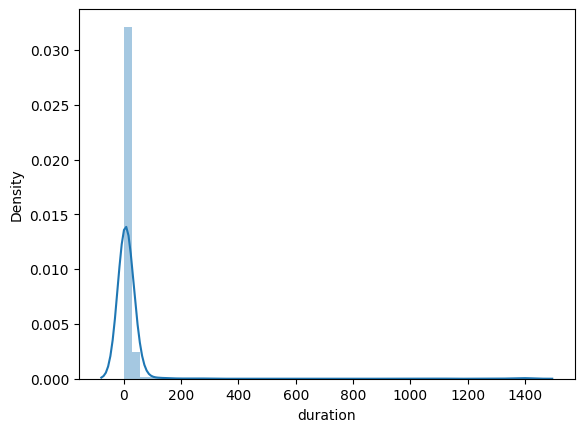

In [13]:
sns.distplot(df.duration)

In [14]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    1238.000000
mean       18.305493
std       108.364382
min         0.000000
50%         1.666667
95%        35.604167
98%        59.339333
99%       149.837833
max      1416.100000
Name: duration, dtype: float64

In [15]:
((df.duration >= 1) & (df.duration <= 60)).mean()

0.5169628432956381

In [16]:
((df.duration >= 0 ) & (df.duration <= 60)).mean()

0.9798061389337641

Trips between duration between 1 min and 60 mins are approximately over 51%.<br>
Trips under duration of 60 mins are about 98%. <br>
That means a lot of trips are less than 1 minutes.<br>
Lecturer tested again without filtering trip type 2.

In [17]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

In [18]:
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime

In [19]:
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

In [20]:
df.duration.describe(percentiles=[0.95, 0.98, 0.99])

count    76518.000000
mean        19.927896
std         59.338594
min          0.000000
50%         13.883333
95%         44.000000
98%         56.000000
99%         67.158167
max       1439.600000
Name: duration, dtype: float64

/tmp/ipykernel_27732/3426635498.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.duration)


<Axes: xlabel='duration', ylabel='Density'>

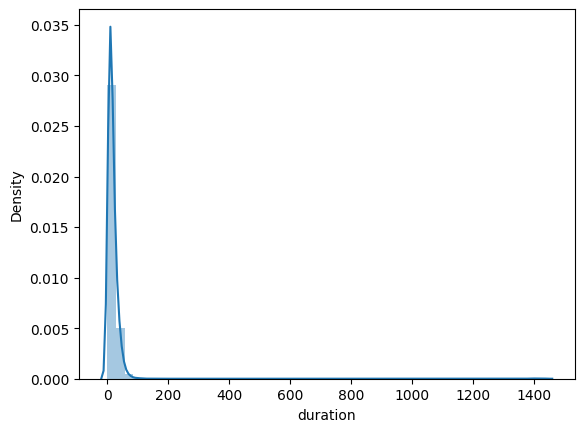

In [21]:
sns.distplot(df.duration)

In [22]:
((df.duration >= 1) & (df.duration <= 60)).mean()

0.9658903787344154

As for features, PULocationID, DOLocationID and trip distance are choosen. 

In [23]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [24]:
df[categorical] = df[categorical].astype(str)

In [25]:
df[categorical + numerical].iloc[:10].to_dict(orient='records')

[{'PULocationID': '43', 'DOLocationID': '151', 'trip_distance': 1.01},
 {'PULocationID': '166', 'DOLocationID': '239', 'trip_distance': 2.53},
 {'PULocationID': '41', 'DOLocationID': '42', 'trip_distance': 1.12},
 {'PULocationID': '168', 'DOLocationID': '75', 'trip_distance': 1.99},
 {'PULocationID': '265', 'DOLocationID': '265', 'trip_distance': 0.0},
 {'PULocationID': '265', 'DOLocationID': '265', 'trip_distance': 0.0},
 {'PULocationID': '265', 'DOLocationID': '265', 'trip_distance': 0.0},
 {'PULocationID': '75', 'DOLocationID': '75', 'trip_distance': 0.45},
 {'PULocationID': '225', 'DOLocationID': '225', 'trip_distance': 0.0},
 {'PULocationID': '225', 'DOLocationID': '265', 'trip_distance': 12.19}]

In [26]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']
    df[categorical] = df[categorical].astype(str)

    return df

In [27]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [28]:
len(df_train), len(df_val)

(73908, 61921)

In [29]:
df_train.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


In [30]:
df_val.head(5)

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-02-01 00:34:03,2021-02-01 00:51:58,N,1.0,130,205,5.0,3.66,14.0,...,0.5,10.00,0.0,None,0.3,25.30,1.0,1.0,0.00,17.916667
1,2,2021-02-01 00:04:00,2021-02-01 00:10:30,N,1.0,152,244,1.0,1.10,6.5,...,0.5,0.00,0.0,None,0.3,7.80,2.0,1.0,0.00,6.500000
2,2,2021-02-01 00:18:51,2021-02-01 00:34:06,N,1.0,152,48,1.0,4.93,16.5,...,0.5,0.00,0.0,None,0.3,20.55,2.0,1.0,2.75,15.250000
3,2,2021-02-01 00:53:27,2021-02-01 01:11:41,N,1.0,152,241,1.0,6.70,21.0,...,0.5,0.00,0.0,None,0.3,22.30,2.0,1.0,0.00,18.233333
4,2,2021-02-01 00:57:46,2021-02-01 01:06:44,N,1.0,75,42,1.0,1.89,8.5,...,0.5,2.45,0.0,None,0.3,12.25,1.0,1.0,0.00,8.966667


In [31]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

In [32]:
dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [33]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [34]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

10.499110712717727

In [35]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

10.481255832596219

In [36]:
lr = Ridge(alpha=0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

10.47641000263633

In [37]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [38]:
categorical = ['PU_DO']

In [39]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [40]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

9.233436225720547

In [41]:
lr = Ridge(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.51044109720127

In [42]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.758715209663881

In [43]:
os.makedirs('models', exist_ok=True)

with open('models/lin_reg.bin','wb') as fout:
    pickle.dump((dv,lr),fout)